In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [2]:
df = pd.read_csv('/content/UCI_Credit_Card.csv')
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)
df.drop(columns=['ID'], inplace=True)


default
0    23364
1     6636
Name: count, dtype: int64


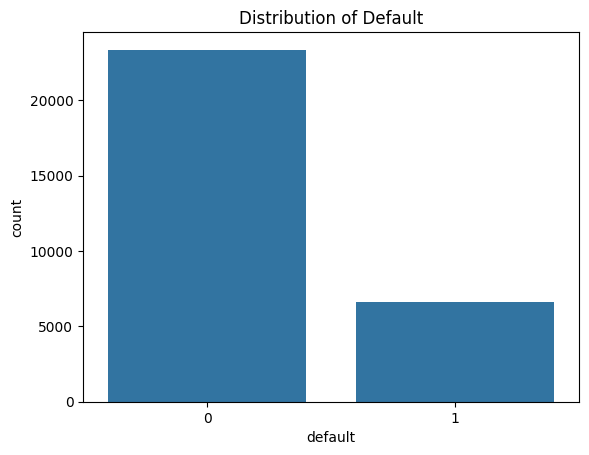

In [3]:
print(df['default'].value_counts())
sns.countplot(x='default', data=df)
plt.title("Distribution of Default")
plt.show()


/tmp/ipython-input-4-1037729049.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="default", y="LIMIT_BAL", data=df, palette="Set2")


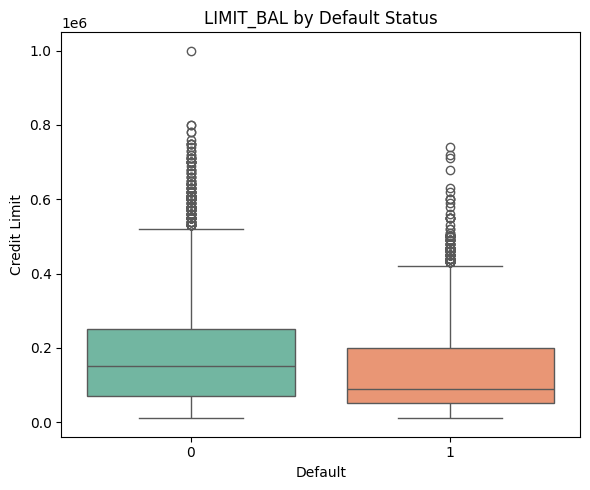

In [4]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="default", y="LIMIT_BAL", data=df, palette="Set2")
plt.title("LIMIT_BAL by Default Status")
plt.xlabel("Default")
plt.ylabel("Credit Limit")
plt.tight_layout()
plt.savefig("boxplot_limitbal_default.png")

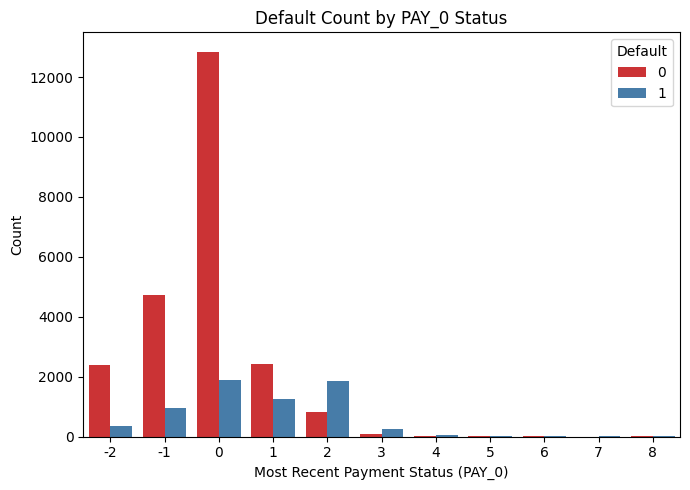

In [5]:
plt.figure(figsize=(7, 5))
sns.countplot(x="PAY_0", hue="default", data=df, palette="Set1")
plt.title("Default Count by PAY_0 Status")
plt.xlabel("Most Recent Payment Status (PAY_0)")
plt.ylabel("Count")
plt.legend(title="Default")
plt.tight_layout()
plt.savefig("countplot_default_pay0.png")

In [6]:
X = df.drop(columns=['default'])
y = df['default']


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)


In [8]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]


In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


In [10]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:23:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\nModel: {name}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")

evaluate_model("Logistic Regression", y_test, y_pred_logreg, y_proba_logreg)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)



Model: Logistic Regression
[[6825  215]
 [1505  455]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7040
           1       0.68      0.23      0.35      1960

    accuracy                           0.81      9000
   macro avg       0.75      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

ROC AUC: 0.7230

Model: Random Forest
[[6607  433]
 [1249  711]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.36      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

ROC AUC: 0.7551

Model: XGBoost
[[6587  453]
 [1233  727]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.37      0.46      1960

   

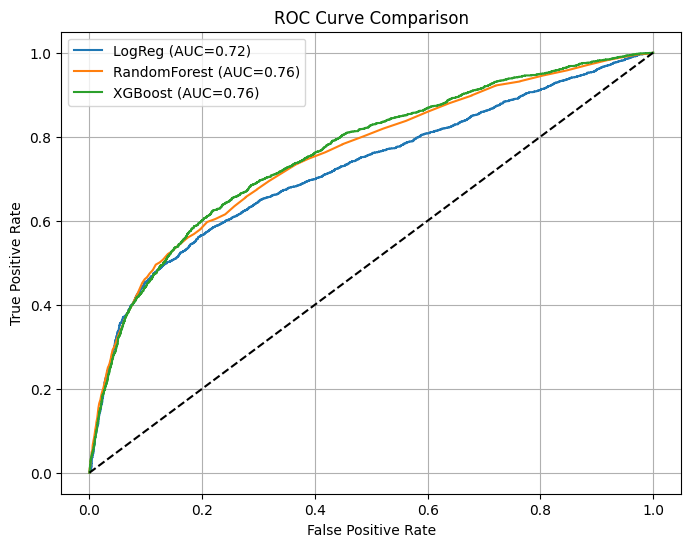

In [15]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={roc_auc_score(y_test, y_proba_logreg):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test, y_proba_xgb):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


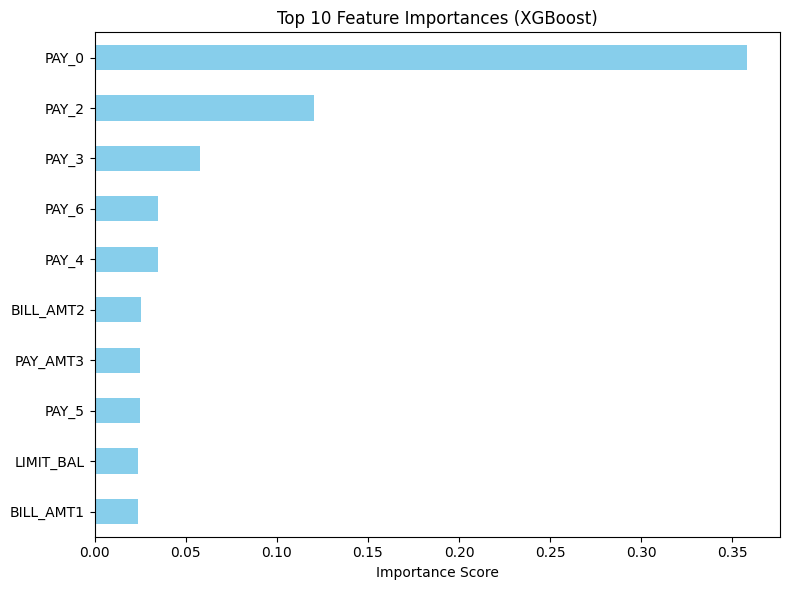

In [14]:
importances = pd.Series(xgb.feature_importances_, index=X.columns)
top10 = importances.nlargest(10)

plt.figure(figsize=(8, 6))
top10.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("top10_feature_importances.png")